In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# zscore
from scipy.stats import zscore
# scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import *
# partitioning
from sklearn.model_selection import train_test_split
# naive bayes
from sklearn.naive_bayes import GaussianNB, CategoricalNB
# plot things
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
# pattern mining
from fim import apriori

In [2]:
df = pd.read_csv("ravdess_features.csv")
# dimensioni grafico e font
plt.rcParams["figure.figsize"] = [12, 8]

# Classification

### Choice of attributes

Each of us select a classification method and then select two variables, one to be classified by ourselves and one to be compared with the other methods, as clustering.
Classification methods:

* Naive Bayes - Claudio
* kNN - Andrea
* Decision trees - Steffania

Possible variables:

* emotion, emotion_positivity, emotional_intensity, sex

We select these variables because they seems to us the most interesting variables to predict.

## Partitioning and Naive Bayes

In [3]:
def get_emotion_positivity(x):
    if(x == 'fearful' or x == 'angry' or x =='sad' or x == 'disgust'):
        return -1;
    if(x == 'happy' or x == 'surprised'): # is calm positive?
        return 1;
    return 0;

df["emotion_positivity"] = df["emotion"].map(get_emotion_positivity)

In [4]:
df["length"] = df["length_ms"] / 1000
df["zero_crossings_rate"] = df["zero_crossings_sum"] / df["length"]
df['statement'] = df['statement'].replace(['Dogs are sitting by the door'], '0')
df['statement'] = df['statement'].replace(['Kids are talking by the door'], '1')
df = df.drop(columns=["length_ms", "zero_crossings_sum"])
df_orig = df.copy()

In [5]:
df = df.drop(columns = ["modality", "vocal_channel", "statement", "repetition", "actor", "channels", "frame_width"]).dropna()
df.T

,0,2,3,4,5,7,8,13,14,15,...,2438,2439,2440,2441,2442,2443,2446,2448,2450,2451
emotion,fearful,happy,surprised,happy,fearful,neutral,calm,calm,sad,sad,...,fearful,calm,neutral,sad,sad,calm,sad,calm,surprised,neutral
emotional_intensity,normal,strong,normal,strong,normal,normal,normal,strong,normal,normal,...,normal,normal,normal,strong,strong,normal,normal,normal,normal,normal
sex,F,F,F,F,F,F,F,F,F,F,...,M,M,M,M,M,M,M,M,M,M
sample_width,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
frame_rate,48000,48000,48000,48000,48000,48000,48000,48000,48000,48000,...,48000,48000,48000,48000,48000,48000,48000,48000,48000,48000
frame_count,179379.0,224224.0,174575.0,211411.0,171371.0,164965.0,180981.0,216216.0,241842.0,233833.0,...,152152.0,168168.0,168168.0,254655.0,233834.0,184184.0,240240.0,200200.0,179379.0,184184.0
intensity,-36.793432,-32.290737,-49.019839,-31.214503,-36.312244,-49.095042,-45.906837,-54.745974,-43.82335,-35.549252,...,-48.653291,-43.782281,-43.906073,-26.666414,-29.512788,-47.141749,-36.811776,-43.342901,-45.751265,-40.018044
mfcc_mean,-33.485947,-30.532463,-36.059555,-31.405996,-30.500889,-36.048576,-33.899364,-34.821735,-38.21092,-32.44183,...,-30.060055,-26.460697,-26.366121,-20.926167,-22.787794,-28.68281,-24.80522,-31.160332,-28.242815,-29.019236
mfcc_std,134.65486,126.57711,159.72516,122.125824,132.58173,167.65213,159.19762,164.23001,151.0448,133.17375,...,166.5965,156.47433,149.74036,112.79364,113.3493,154.49243,138.31459,157.4997,159.9434,149.18895
mfcc_min,-755.22345,-726.06036,-842.94635,-700.70276,-719.16547,-910.49744,-879.26,-926.8722,-863.7997,-747.3212,...,-875.4503,-814.579,-802.8734,-657.04,-659.3891,-859.21173,-782.33734,-825.3741,-868.09576,-799.5101


#### Gaussian

In [6]:
def naive_bayes(df, pred):
    y = np.array(df[pred])
    categorical_cols = ["emotion", "sex", "emotion_positivity", "emotional_intensity"]
    df = pd.get_dummies(df, columns=categorical_cols)
    X = df.values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=0
    )
    print("Stratify:\n")
    print(np.unique(y, return_counts=True)[1] / len(y))
    print(np.unique(y_train, return_counts=True)[1] / len(y_train))
    print(np.unique(y_test, return_counts=True)[1] / len(y_test))
    print("\nShapes:\n")
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, "\n")
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Classification report:\n")
    clf_report = classification_report(y_test, y_pred, output_dict = True)
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot = True)
    #plt.savefig('clfreport_' + pred + '.png')
    plt.show()
    print("ROC curve:\n")
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    plt.rcParams["figure.figsize"] = [12, 8]
    plot_roc(y_test, clf.predict_proba(X_test))
    #plt.savefig('roc_' + pred + '.png')
    plt.show()
    try:
        print("ROC AUC score: ", roc_auc_score(y_test, clf.predict_proba(X_test), multi_class="ovr", average="macro"))
    except ValueError:
        pass
    print("\nConfusion matrix:\n")
    cf = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf, annot=True, cmap="Greens", fmt = 'g')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    #plt.savefig('cm_' + pred + '.png')
    plt.show()

##### "Emotion"

Stratify:

[0.15158924 0.15403423 0.08312958 0.15403423 0.150978   0.07823961
 0.14914425 0.07885086]
[0.15196507 0.15371179 0.08296943 0.15371179 0.1510917  0.07860262
 0.14934498 0.07860262]
[0.15071283 0.15478615 0.08350305 0.15478615 0.15071283 0.07739308
 0.14867617 0.07942974]

Shapes:

(1145, 43) (491, 43) (1145,) (491,) 

Classification report:



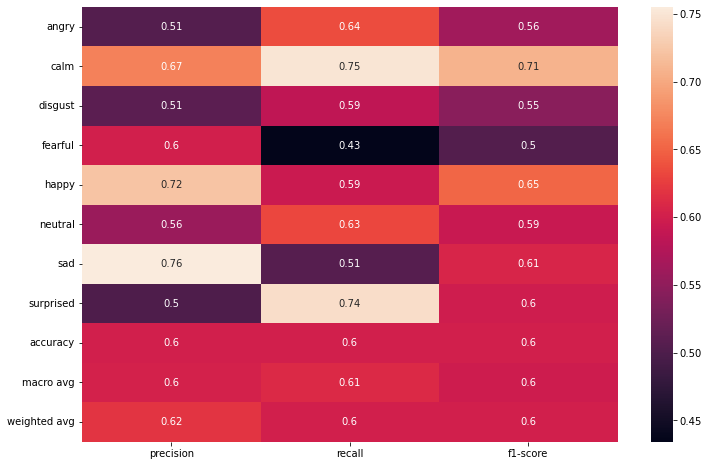

ROC curve:



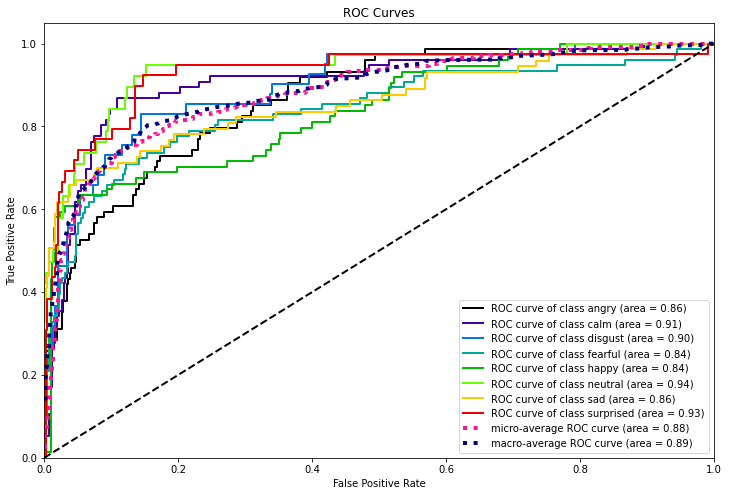

ROC AUC score:  0.8839137589640433

Confusion matrix:



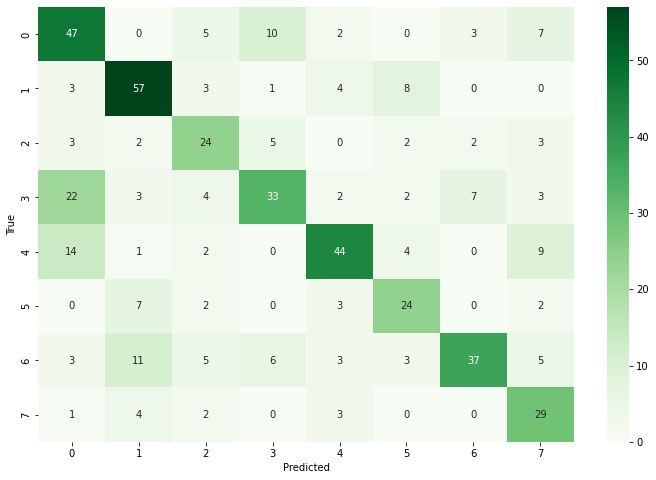

In [7]:
var_pred = "emotion" # <--- this is the variable prediction parameter
naive_bayes(df, var_pred)

Poor model reliability for the _emotion_ prediction, because the accuracy is of 60%. The highest precision is of _sad_ class with 0.76, which has the best TP/FP ratio and the lowest FP support. The highest recall is of _calm_ class with 0.75, which has the best TP/FN ratio but not the lowest FN support. Also the _calm_ class has precision of 0.67 and is the most "balanced" class, for this reason the highest f1-score is of _calm_ class, since the latter is both sensitive to FP and FN.

In confusion matrix we have another proof of the _calm_ class which has the highest TP support. We can also see that the _fearful_ class has the highest FN support, in fact it has also the lowest recall (0.43), since the latter is sensitive to FN.

In ROC curve plot we see what we can expect from everything we have said so far: the _calm_ class has a high area value, lower only than _surprised_ and _neutral_ classes but they have a much lower support than _calm_ one.

##### "Sex"

Stratify:

[0.48288509 0.51711491]
[0.48296943 0.51703057]
[0.48268839 0.51731161]

Shapes:

(1145, 43) (491, 43) (1145,) (491,) 

Classification report:



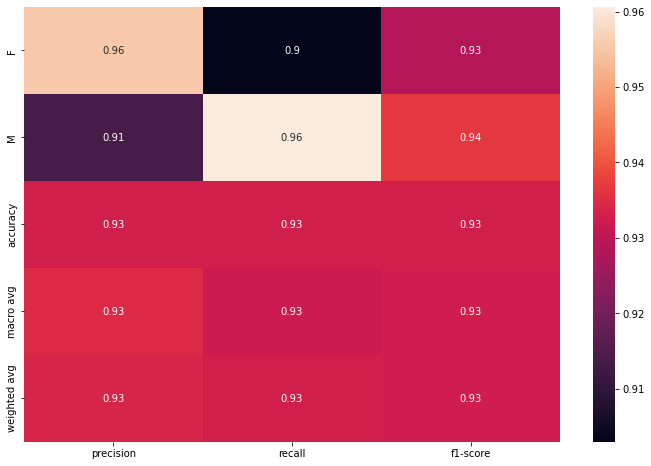

ROC curve:



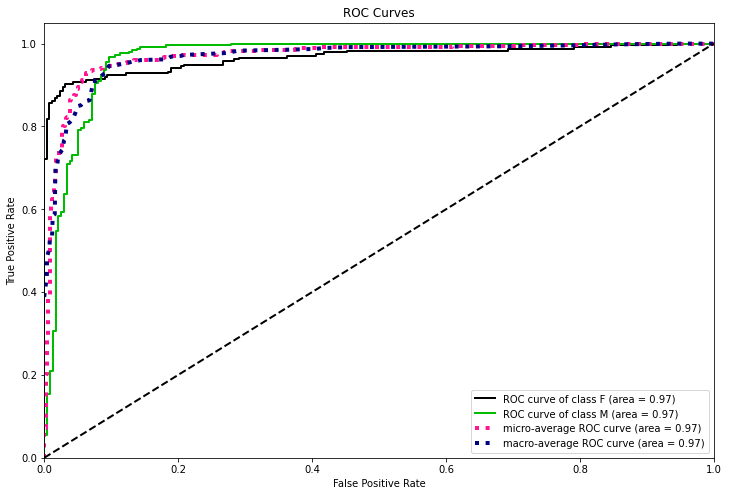


Confusion matrix:



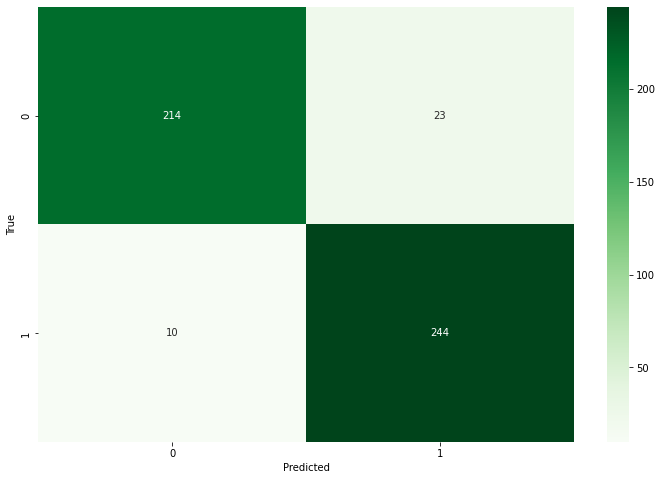

In [8]:
var_pred = "sex" # <--- this is the variable prediction parameter
naive_bayes(df, var_pred)

This case is not really interesting. The _sex_ accuracy (93%) is higher than the _emotion_ one, it is also the highest accuracy among all the chosen attributes, but we have also to take into account that _sex_ is binary class problem. The _female_ class has an higher precision (0.96) than _male_, in fact it has only 10 FP out of 491, but the highest recall is of _male_ class (0.96), that means _female_ has an higher FN value, 23 out of 491. However these numbers are really small compared to the total support and the differences are not so significant, in fact the f1-scores are similar, respectively 0.93 for _female_ and 0.94 for _male_.

##### "emotional_intensity"

Stratify:

[0.53178484 0.46821516]
[0.53187773 0.46812227]
[0.53156823 0.46843177]

Shapes:

(1145, 43) (491, 43) (1145,) (491,) 

Classification report:



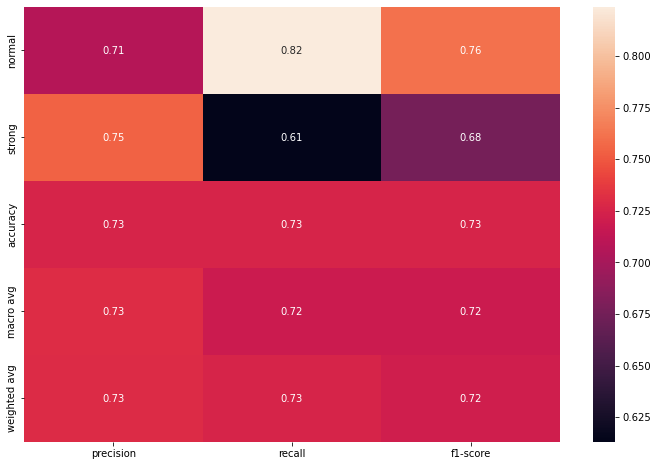

ROC curve:



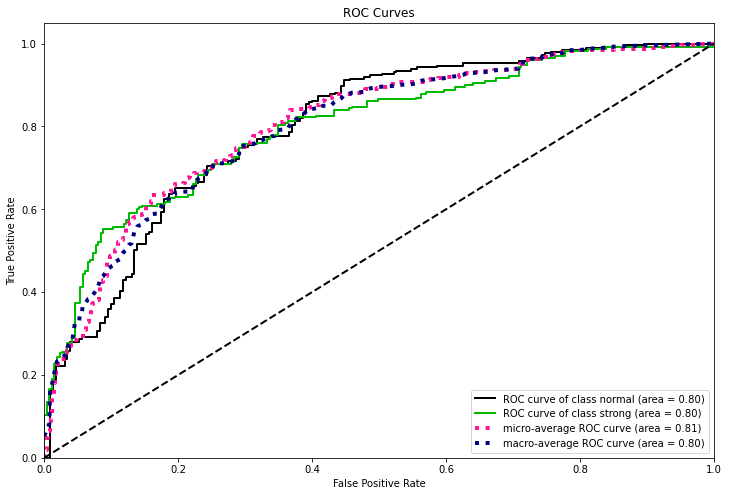


Confusion matrix:



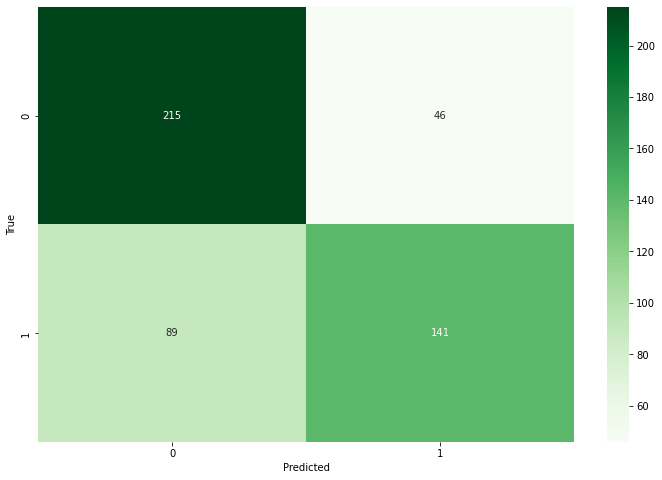

In [9]:
var_pred = "emotional_intensity" # <--- this is the variable prediction parameter
naive_bayes(df, var_pred)

This case is more interesting than _sex_ attribute, despite also _emotional_intensity_ is a binary class problem but accuracy is lower than the _sex_ one (73% vs 93%). Precisions are similar among classes, with _strong_ class which has a slightly higher value (0.75 vs 0.71). The recall is much higher in _normal_ class (0.82 vs 0.61), which has also an higher f1-score (0.76 vs 0.68).

In confusion matrix we can see an higher FP value (89), which is quite close to the TN value (141).

##### "emotion_positivity"

Stratify:

[0.53789731 0.23227384 0.22982885]
[0.53799127 0.23231441 0.22969432]
[0.53767821 0.23217923 0.23014257]

Shapes:

(1145, 43) (491, 43) (1145,) (491,) 

Classification report:



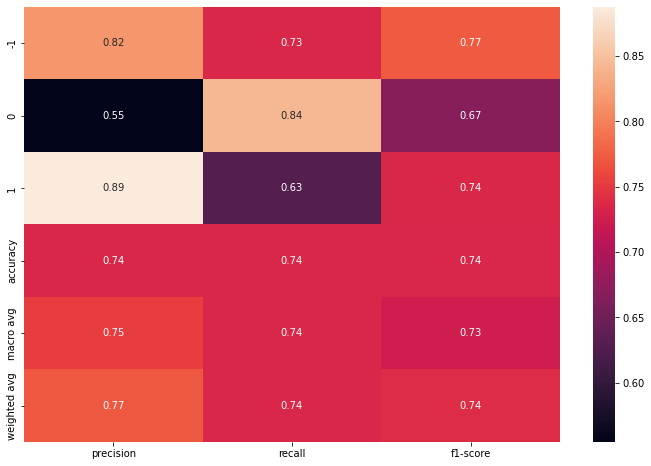

ROC curve:



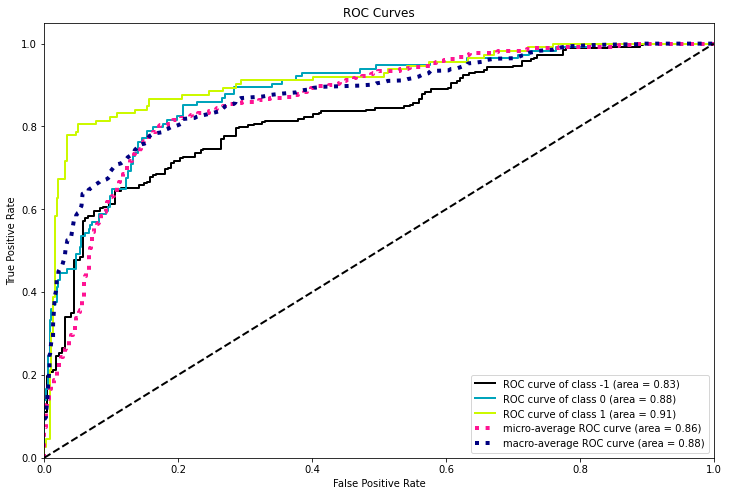

ROC AUC score:  0.8739691710917837

Confusion matrix:



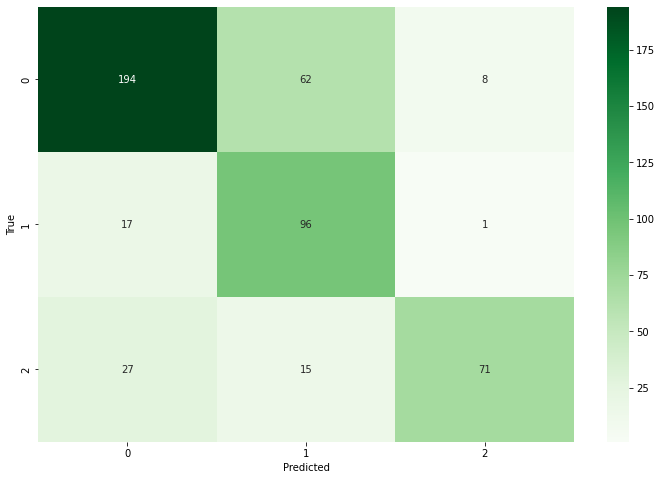

In [10]:
var_pred = "emotion_positivity" # <--- this is the variable prediction parameter
naive_bayes(df, var_pred)

The last one is _emotion_positivity_ attribute, which is a three-class problem with the accuracy slightly higher than the _emotional_intensity_ one (74% vs 73%). The positive emotions, the _1_ class, have the highest precision (0.89), in fact they have only 9 out of 113 FP. On the other side positive emotions have the lowest recall, consequently the highest FN value (42), while the highest recall is of neutral emotions, the _0_ class, which is 0.84. The f1-score but with much higher support. The highest recall is of neutral emotions, which is of 0.84, with the lowest number of FN (18).

In confusion matrix we can see there is a spike of predicted neutral emotions which they actually are negative emotions, 62, which is quite close to positive emotions TP value (71).

#### Categorical

In [11]:
def naive_bayes_cat(df, pred):
    y = np.array(df[pred])
    categorical_cols = ["emotion", "sex", "emotion_positivity", "emotional_intensity"]
    df = pd.get_dummies(df, columns=categorical_cols)
    X = df.values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=0
    )
    non_cat_columns = [ # commented variables contain redundant values that prevent NB from working properly
        "intensity",
        "zero_crossings_rate",
        "length",
        ##"frame_count",
        #"sample_width",
        #"frame_rate",
        "mfcc_mean",
        ##"mfcc_min",
        "mfcc_max",
        ##"mfcc_std",
        "sc_mean",
        #"sc_min",
        "sc_max",
        "sc_std",
        "sc_kur",
        "sc_skew",
        "stft_mean",
        #"stft_min",
        #"stft_max",
        "stft_std",
        "stft_kur",
        ##"stft_skew",
        ##"mean",
        ##"std",
        ##"min",
        ##"max",
        "skew",
        "kur"
    ]

    X_noncat = df[non_cat_columns].values

    X_train_noncat, X_test_noncat, y_train_noncat, y_test_noncat = train_test_split(
        X_noncat, y, test_size=0.3, stratify=y, random_state=0
    )

    # train and test set should be binned separately
    X_train_cat = list()
    for column_idx in range(X_train_noncat.shape[1]):
        X_train_cat.append(pd.qcut(X_train_noncat[:, column_idx], q=4, labels=False))
    X_train_cat = np.array(X_train_cat).T

    X_test_cat = list()
    for column_idx in range(X_test_noncat.shape[1]):
        X_test_cat.append(pd.qcut(X_test_noncat[:, column_idx], q=4, labels=False))
    X_test_cat = np.array(X_test_cat).T

    print("Shapes:\n")
    print(X_train_cat.shape, X_test_cat.shape)
    clf = CategoricalNB()
    clf.fit(X_train_cat, y_train_noncat)
    y_pred = clf.predict(X_test_cat)
    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred))
    print("ROC curve:\n")
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    plt.rcParams["figure.figsize"] = [12, 8]
    plot_roc(y_test_noncat, clf.predict_proba(X_test_cat))
    plt.show()
    try:
        print("ROC AUC score: ", roc_auc_score(y_test_noncat, clf.predict_proba(X_test_cat), multi_class="ovr", average="macro"))
    except ValueError:
        pass
    print("\nConfusion matrix:\n")
    cf = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf, annot=True, cmap="Greens", fmt = 'g')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

##### "Emotion"

Shapes:

(1145, 15) (491, 15)

Classification report:

              precision    recall  f1-score   support

       angry       0.37      0.51      0.43        74
        calm       0.49      0.39      0.44        76
     disgust       0.35      0.46      0.40        41
     fearful       0.50      0.36      0.42        76
       happy       0.26      0.14      0.18        74
     neutral       0.14      0.08      0.10        38
         sad       0.23      0.19      0.21        73
   surprised       0.24      0.62      0.35        39

    accuracy                           0.34       491
   macro avg       0.32      0.34      0.32       491
weighted avg       0.34      0.34      0.32       491

ROC curve:



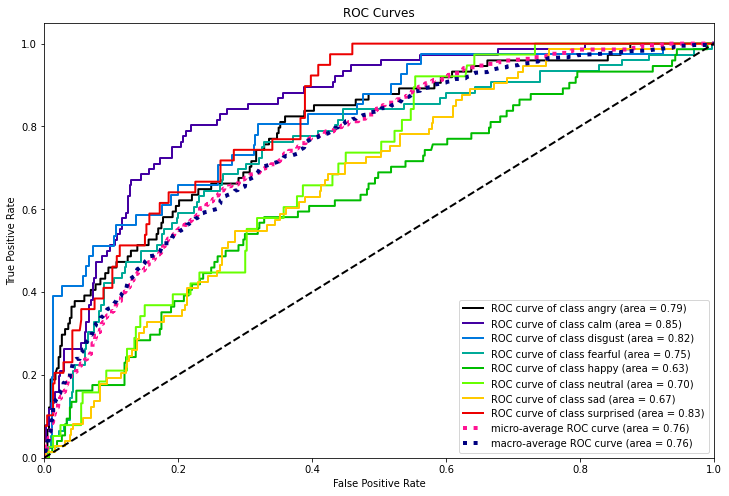

ROC AUC score:  0.7542135627320876

Confusion matrix:



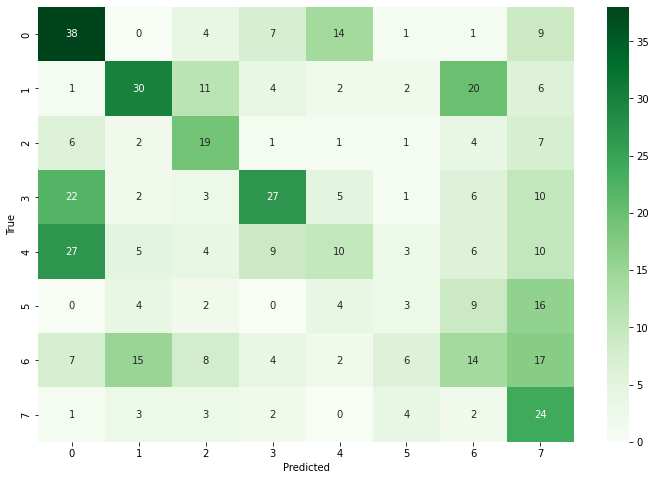

In [12]:
var_pred = "emotion" # <--- this is the variable prediction parameter
naive_bayes_cat(df, var_pred)

Very low reliability as regards the prediction of _emotion_ on the Categorical. The score of categorical test is lower than non categorical one.

##### "Sex"

Shapes:

(1145, 15) (491, 15)

Classification report:

              precision    recall  f1-score   support

           F       0.90      0.84      0.87       237
           M       0.86      0.92      0.89       254

    accuracy                           0.88       491
   macro avg       0.88      0.88      0.88       491
weighted avg       0.88      0.88      0.88       491

ROC curve:



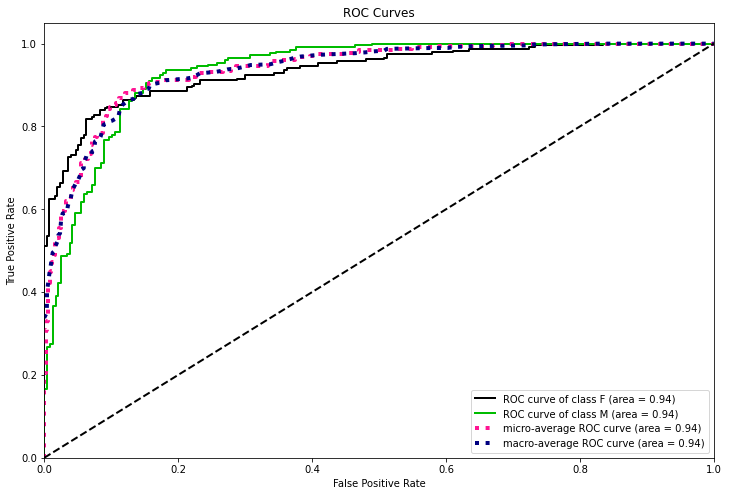


Confusion matrix:



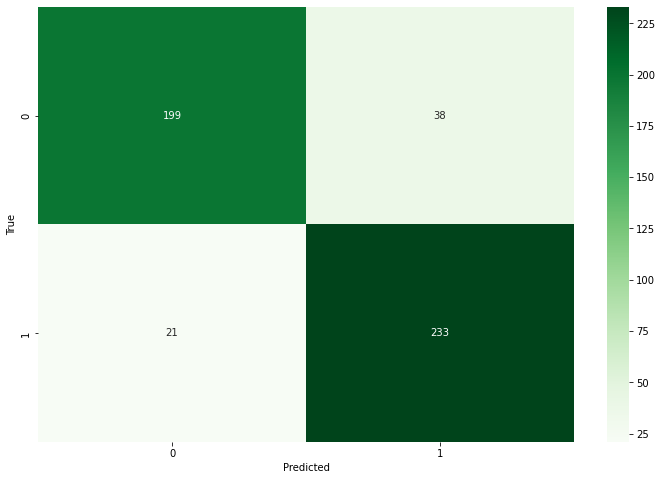

In [13]:
var_pred = "sex" # <--- this is the variable prediction parameter
naive_bayes_cat(df, var_pred)

##### "emotional_intensity"

Shapes:

(1145, 15) (491, 15)

Classification report:

              precision    recall  f1-score   support

      normal       0.68      0.72      0.70       261
      strong       0.66      0.62      0.64       230

    accuracy                           0.67       491
   macro avg       0.67      0.67      0.67       491
weighted avg       0.67      0.67      0.67       491

ROC curve:



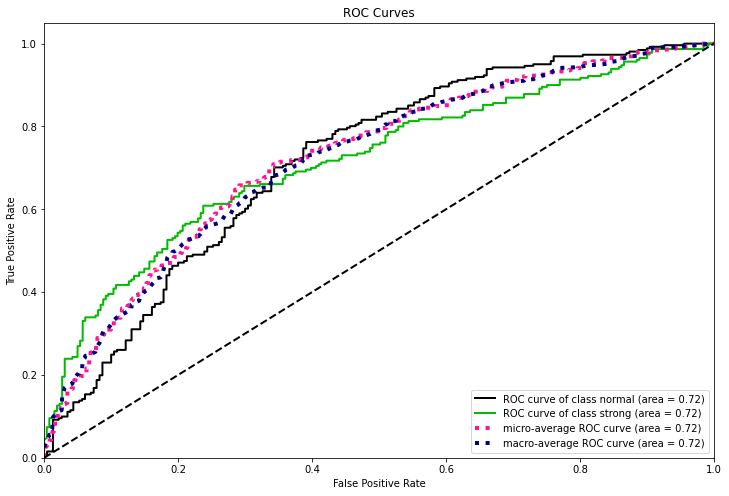


Confusion matrix:



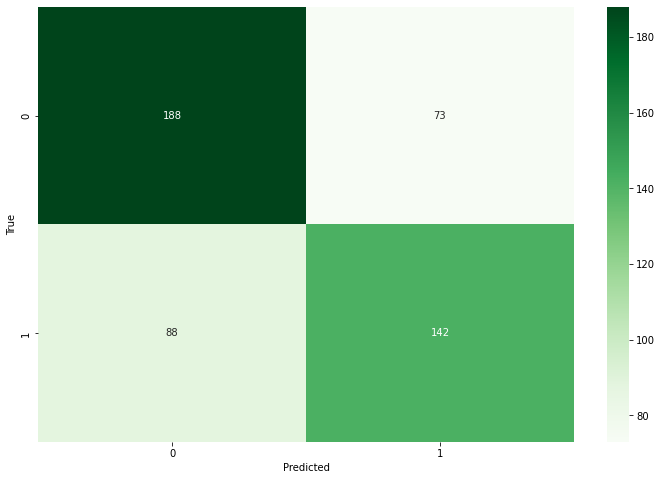

In [14]:
var_pred = "emotional_intensity" # <--- this is the variable prediction parameter
naive_bayes_cat(df, var_pred)

##### "emotion_positivity"

Shapes:

(1145, 15) (491, 15)

Classification report:

              precision    recall  f1-score   support

          -1       0.61      0.60      0.61       264
           0       0.48      0.60      0.53       114
           1       0.34      0.27      0.30       113

    accuracy                           0.52       491
   macro avg       0.48      0.49      0.48       491
weighted avg       0.52      0.52      0.52       491

ROC curve:



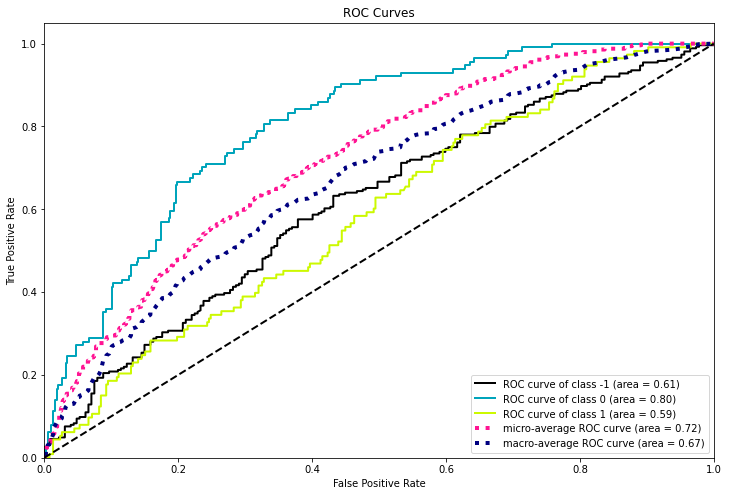

ROC AUC score:  0.6691653146936383

Confusion matrix:



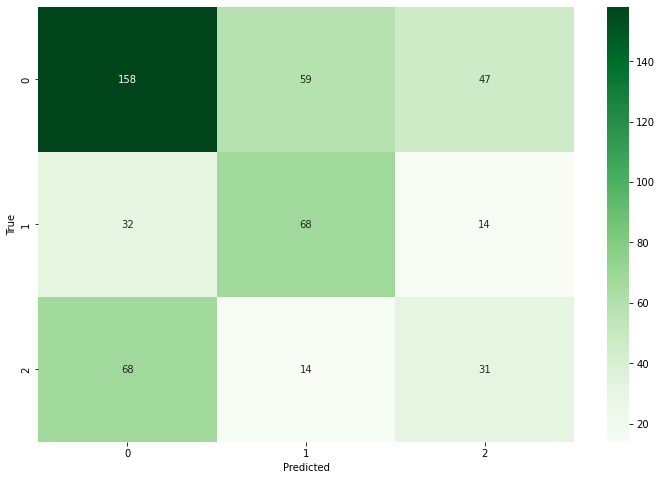

In [15]:
var_pred = "emotion_positivity" # <--- this is the variable prediction parameter
naive_bayes_cat(df, var_pred)

# Pattern mining

### Preprocessing

In [16]:
correlation_drop_cols = ["std", "mfcc_min", "max", "mfcc_std", "stft_skew", "min", "frame_count", "modality", "statement", "vocal_channel", "repetition"]
df_orig = df_orig.drop(columns = correlation_drop_cols).dropna()
columns = df_orig.columns.tolist()
delete = ["emotion", "emotional_intensity", "sex", "emotion_positivity"]
n_clms = [ele for ele in columns if ele not in delete] #numerical columns
n_clms.remove('sc_min')
n_clms.remove('stft_min')
for v in n_clms:
    df_orig[v + "_Bins"] = pd.qcut(df_orig[v].rank(method='first'),4)
df_orig["sc_min_Bins"] = pd.qcut(df_orig["sc_min"].rank(method='first'),4)
df_orig["stft_min_Bins"] = pd.qcut(df_orig["stft_min"].rank(method='first'),4)
emposi_dict = {-1: "-1_emp", 0: "0_emp", 1: "1_emp"}
df_orig["emo_positivityclass"] = df_orig["emotion_positivity"].map(emposi_dict)
df_orig.drop(n_clms, axis=1, inplace=True)
df_orig.drop([ 'emotion_positivity', 'sc_min', 'stft_min'], axis=1, inplace=True)
n_clms.append('sc_min')
n_clms.append('stft_min')

In [17]:
n2_clms=df_orig.columns.tolist()
n2_clms = n2_clms[3:-1]
len(n2_clms) == len(n_clms)

True

In [18]:
for i in range(len(n_clms)):
    df_orig[n2_clms[i]] = df_orig[n2_clms[i]].astype(str) + "_" + n_clms[i]
X = df_orig.values.tolist()
df_orig.T

,0,2,3,4,8,13,15,16,18,19,...,2428,2431,2433,2435,2438,2439,2441,2446,2448,2451
emotion,fearful,happy,surprised,happy,calm,calm,sad,calm,angry,surprised,...,surprised,angry,happy,surprised,fearful,calm,sad,sad,calm,neutral
emotional_intensity,normal,strong,normal,strong,normal,strong,normal,strong,strong,strong,...,strong,normal,strong,normal,normal,normal,strong,normal,normal,normal
sex,F,F,F,F,F,F,F,F,F,F,...,M,M,M,M,M,M,M,M,M,M
actor_Bins,"(0.999, 218.25]_actor","(435.5, 652.75]_actor","(435.5, 652.75]_actor","(0.999, 218.25]_actor","(218.25, 435.5]_actor","(0.999, 218.25]_actor","(218.25, 435.5]_actor","(218.25, 435.5]_actor","(0.999, 218.25]_actor","(435.5, 652.75]_actor",...,"(0.999, 218.25]_actor","(435.5, 652.75]_actor","(435.5, 652.75]_actor","(218.25, 435.5]_actor","(435.5, 652.75]_actor","(435.5, 652.75]_actor","(435.5, 652.75]_actor","(652.75, 870.0]_actor","(652.75, 870.0]_actor","(652.75, 870.0]_actor"
channels_Bins,"(0.999, 218.25]_channels","(0.999, 218.25]_channels","(0.999, 218.25]_channels","(0.999, 218.25]_channels","(0.999, 218.25]_channels","(0.999, 218.25]_channels","(0.999, 218.25]_channels","(0.999, 218.25]_channels","(0.999, 218.25]_channels","(0.999, 218.25]_channels",...,"(652.75, 870.0]_channels","(652.75, 870.0]_channels","(652.75, 870.0]_channels","(652.75, 870.0]_channels","(652.75, 870.0]_channels","(652.75, 870.0]_channels","(652.75, 870.0]_channels","(652.75, 870.0]_channels","(652.75, 870.0]_channels","(652.75, 870.0]_channels"
sample_width_Bins,"(0.999, 218.25]_sample_width","(0.999, 218.25]_sample_width","(0.999, 218.25]_sample_width","(0.999, 218.25]_sample_width","(0.999, 218.25]_sample_width","(0.999, 218.25]_sample_width","(0.999, 218.25]_sample_width","(0.999, 218.25]_sample_width","(0.999, 218.25]_sample_width","(0.999, 218.25]_sample_width",...,"(652.75, 870.0]_sample_width","(652.75, 870.0]_sample_width","(652.75, 870.0]_sample_width","(652.75, 870.0]_sample_width","(652.75, 870.0]_sample_width","(652.75, 870.0]_sample_width","(652.75, 870.0]_sample_width","(652.75, 870.0]_sample_width","(652.75, 870.0]_sample_width","(652.75, 870.0]_sample_width"
frame_rate_Bins,"(0.999, 218.25]_frame_rate","(0.999, 218.25]_frame_rate","(0.999, 218.25]_frame_rate","(0.999, 218.25]_frame_rate","(0.999, 218.25]_frame_rate","(0.999, 218.25]_frame_rate","(0.999, 218.25]_frame_rate","(0.999, 218.25]_frame_rate","(0.999, 218.25]_frame_rate","(0.999, 218.25]_frame_rate",...,"(652.75, 870.0]_frame_rate","(652.75, 870.0]_frame_rate","(652.75, 870.0]_frame_rate","(652.75, 870.0]_frame_rate","(652.75, 870.0]_frame_rate","(652.75, 870.0]_frame_rate","(652.75, 870.0]_frame_rate","(652.75, 870.0]_frame_rate","(652.75, 870.0]_frame_rate","(652.75, 870.0]_frame_rate"
frame_width_Bins,"(0.999, 218.25]_frame_width","(0.999, 218.25]_frame_width","(0.999, 218.25]_frame_width","(0.999, 218.25]_frame_width","(0.999, 218.25]_frame_width","(0.999, 218.25]_frame_width","(0.999, 218.25]_frame_width","(0.999, 218.25]_frame_width","(0.999, 218.25]_frame_width","(0.999, 218.25]_frame_width",...,"(652.75, 870.0]_frame_width","(652.75, 870.0]_frame_width","(652.75, 870.0]_frame_width","(652.75, 870.0]_frame_width","(652.75, 870.0]_frame_width","(652.75, 870.0]_frame_width","(652.75, 870.0]_frame_width","(652.75, 870.0]_frame_width","(652.75, 870.0]_frame_width","(652.75, 870.0]_frame_width"
intensity_Bins,"(435.5, 652.75]_intensity","(435.5, 652.75]_intensity","(0.999, 218.25]_intensity","(652.75, 870.0]_intensity","(0.999, 218.25]_intensity","(0.999, 218.25]_intensity","(435.5, 652.75]_intensity","(0.999, 218.25]_intensity","(652.75, 870.0]_intensity","(218.25, 435.5]_intensity",...,"(218.25, 435.5]_intensity","(218.25, 435.5]_intensity","(435.5, 652.75]_intensity","(435.5, 652.75]_intensity","(0.999, 218.25]_intensity","(218.25, 435.5]_intensity","(652.75, 870.0]_intensity","(435.5, 652.75]_intensity","(218.25, 435.5]_intensity","(218.25, 435.5]_intensity"
mfcc_mean_Bins,"(0.999, 218.25]_mfcc_mean","(218.25, 435.5]_mfcc_mean"

## Frequent itemset

### zmin = 2

In [19]:
supp = 20  # 20%
zmin = 2  # minimum number of items per item set

itemsets = apriori(X, target="s", supp=supp, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["frequent_itemset", "support"])

,frequent_itemset,support
0,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.942529
1,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.942529
2,"((218.25, 435.5]_stft_max, (218.25, 435.5]_sam...",24.942529
3,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.712644
4,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.712644
...,...,...
117,"(M, normal)",25.977011
118,"(M, -1_emp)",26.666667
119,"(F, normal)",26.666667
120,"(F, -1_emp)",27.241379


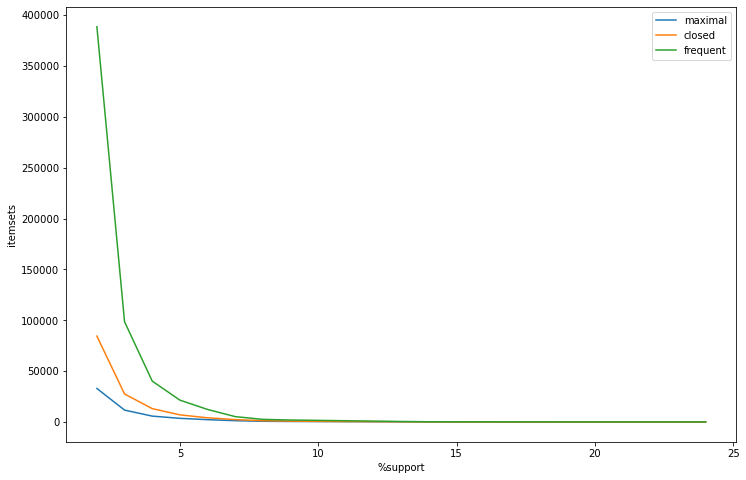

In [20]:
len_max_it = []
len_cl_it = []
len_fre_it = []
max_supp = 25
for i in range(2, max_supp):
    max_itemsets = apriori(X, target="m", supp=i, zmin=zmin)
    cl_itemsets = apriori(X, target="c", supp=i, zmin=zmin)
    fre_itemsets = apriori(X, target="s", supp=i, zmin=2)
    len_max_it.append(len(max_itemsets))
    len_cl_it.append(len(cl_itemsets))
    len_fre_it.append(len(fre_itemsets))

plt.plot(np.arange(2, max_supp), len_max_it, label="maximal")
plt.plot(np.arange(2, max_supp), len_cl_it, label="closed")
plt.plot(np.arange(2, max_supp), len_fre_it, label="frequent")
plt.legend()
plt.xlabel("%support")
plt.ylabel("itemsets")

plt.show()

### zmin = 3

In [21]:
supp = 20  # 20%
zmin = 3  # minimum number of items per item set

itemsets = apriori(X, target="s", supp=supp, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["frequent_itemset", "support"])

,frequent_itemset,support
0,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.942529
1,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.712644
2,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.712644
3,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.712644
4,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.712644
...,...,...
59,"((0.999, 218.25]_frame_rate, (0.999, 218.25]_f...",25.057471
60,"((0.999, 218.25]_frame_rate, (0.999, 218.25]_f...",25.057471
61,"((0.999, 218.25]_frame_rate, (0.999, 218.25]_f...",25.057471
62,"((0.999, 218.25]_frame_rate, (0.999, 218.25]_s...",25.057471


The only itemset found with _zmin_ = 3 is with female sex, normal emotional intensity and sc_min = 0.

### zmin = 4

In [22]:
supp = 20
zmin = 4

itemsets = apriori(X, target="s", supp=supp, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["frequent_itemset", "support"])

,frequent_itemset,support
0,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.712644
1,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.712644
2,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.712644
3,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.712644
4,"((218.25, 435.5]_stft_max, (218.25, 435.5]_cha...",24.712644
5,"((218.25, 435.5]_frame_width, (218.25, 435.5]_...",24.712644
6,"((435.5, 652.75]_sample_width, (435.5, 652.75]...",24.597701
7,"((435.5, 652.75]_sample_width, (435.5, 652.75]...",24.597701
8,"((435.5, 652.75]_sample_width, (435.5, 652.75]...",24.597701
9,"((435.5, 652.75]_sample_width, (435.5, 652.75]...",24.597701


## Closed itemset

In [23]:
supp = 20  # 20%
zmin = 2  # minimum number of items per item set

itemsets = apriori(X, target="c", supp=supp, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["closed_itemset", "support"])

,closed_itemset,support
0,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.712644
1,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.942529
2,"((218.25, 435.5]_frame_width, (218.25, 435.5]_...",24.942529
3,"((435.5, 652.75]_sample_width, (435.5, 652.75]...",24.942529
4,"((435.5, 652.75]_sample_width, (435.5, 652.75]...",24.597701
5,"((435.5, 652.75]_channels, (435.5, 652.75]_fra...",24.942529
6,"((218.25, 435.5]_stft_min, F)",20.344828
7,"((652.75, 870.0]_sample_width, (652.75, 870.0]...",24.712644
8,"((652.75, 870.0]_sample_width, (652.75, 870.0]...",25.057471
9,"((652.75, 870.0]_frame_width, (652.75, 870.0]_...",25.057471


## Maximal itemset

In [24]:
itemsets = apriori(X, target="m", supp=supp, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["maximal_itemset", "support"])

,maximal_itemset,support
0,"((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",24.712644
1,"((435.5, 652.75]_sample_width, (435.5, 652.75]...",24.597701
2,"((218.25, 435.5]_stft_min, F)",20.344828
3,"((652.75, 870.0]_sample_width, (652.75, 870.0]...",24.712644
4,"((652.75, 870.0]_stft_min, M)",24.712644
5,"((652.75, 870.0]_mfcc_mean, M)",21.034483
6,"((0.999, 218.25]_stft_std, M)",22.528736
7,"((652.75, 870.0]_stft_std, F)",22.528736
8,"((0.999, 218.25]_stft_mean, F)",23.103448
9,"((0.999, 218.25]_sample_width, (0.999, 218.25]...",25.057471


### Support vs number of itemsets

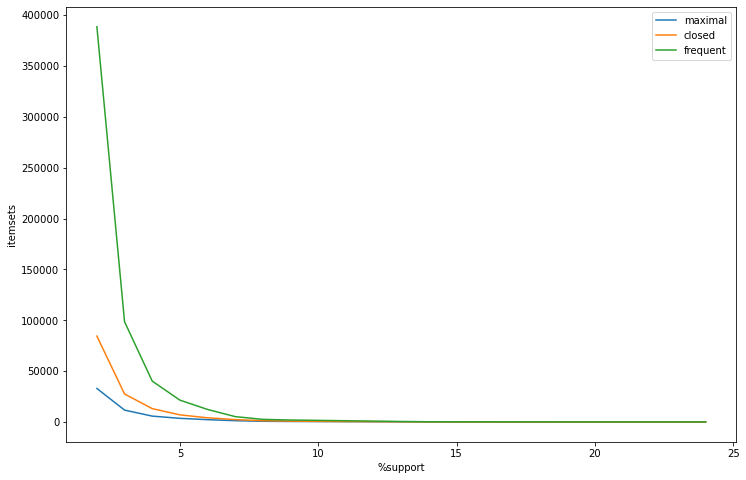

In [25]:
len_max_it = []
len_cl_it = []
len_fre_it = []
max_supp = 25
for i in range(2, max_supp):
    max_itemsets = apriori(X, target="m", supp=i, zmin=zmin)
    cl_itemsets = apriori(X, target="c", supp=i, zmin=zmin)
    fre_itemsets = apriori(X, target="s", supp=i, zmin=2)
    len_max_it.append(len(max_itemsets))
    len_cl_it.append(len(cl_itemsets))
    len_fre_it.append(len(fre_itemsets))

plt.plot(np.arange(2, max_supp), len_max_it, label="maximal")
plt.plot(np.arange(2, max_supp), len_cl_it, label="closed")
plt.plot(np.arange(2, max_supp), len_fre_it, label="frequent")
plt.legend()
plt.xlabel("%support")
plt.ylabel("itemsets")

plt.show()

### Support vs number of itemsets for normal/strong emotional_intensity

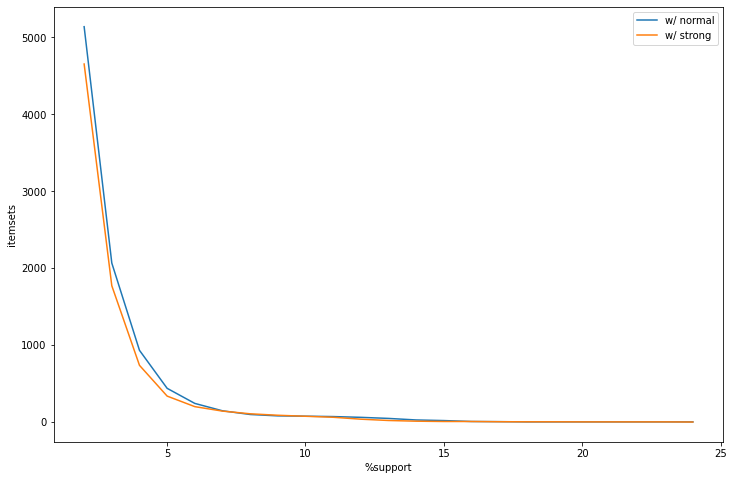

In [26]:
filter_1 = []
filter_2 = []
for i in range(2, max_supp):
    max_itemsets = apriori(X, target="m", supp=i, zmin=zmin)
    filter_1.append(len([item for item in max_itemsets if "normal" in item[0]]))
    filter_2.append(len([item for item in max_itemsets if "strong" in item[0]]))

plt.plot(np.arange(2, max_supp), filter_1, label="w/ normal")
plt.plot(np.arange(2, max_supp), filter_2, label="w/ strong")
plt.legend()
plt.xticks()
plt.xlabel("%support")
plt.ylabel("itemsets")

plt.show()

## Association rules

In [27]:
conf = 60
rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
rules_df.sort_values(by="lift", axis=0, ascending=False)

,consequent,antecedent,abs_support,%_support,confidence,lift
0,happy,"(1_emp,)",127,14.597701,0.651282,4.461538
1,calm,"(0_emp,)",138,15.862069,0.669903,4.223301
65,"(435.5, 652.75]_sample_width","((435.5, 652.75]_frame_width, (435.5, 652.75]_...",214,24.597701,1.000000,4.009217
106,"(218.25, 435.5]_frame_width","((218.25, 435.5]_stft_max, (218.25, 435.5]_cha...",215,24.712644,1.000000,4.009217
105,"(218.25, 435.5]_channels","((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",215,24.712644,1.000000,4.009217
...,...,...,...,...,...,...
388,normal,"((652.75, 870.0]_stft_std, F)",118,13.563218,0.602041,1.143615
371,normal,"((652.75, 870.0]_sc_mean,)",131,15.057471,0.600917,1.141481
179,-1_emp,"((652.75, 870.0]_stft_min,)",133,15.287356,0.610092,1.131727
407,-1_emp,"((652.75, 870.0]_skew,)",132,15.172414,0.605505,1.123217


In [28]:
rules_df[rules_df["consequent"] == "F"].sort_values(by="lift", axis=0, ascending=False)

,consequent,antecedent,abs_support,%_support,confidence,lift
357,F,"((0.999, 218.25]_mfcc_mean,)",203,23.333333,0.931193,1.845416
390,F,"((0.999, 218.25]_stft_mean,)",201,23.103448,0.922018,1.827235
389,F,"((652.75, 870.0]_stft_std,)",196,22.528736,0.899083,1.781781
361,F,"((0.999, 218.25]_mfcc_max,)",195,22.413793,0.894495,1.772690
160,F,"((218.25, 435.5]_stft_min,)",177,20.344828,0.815668,1.616472
410,F,"((652.75, 870.0]_zero_crossings_rate,)",169,19.425287,0.775229,1.536332
403,F,"((0.999, 218.25]_stft_min, (0.999, 218.25]_sc_...",161,18.505747,0.738532,1.463606
406,F,"((0.999, 218.25]_stft_min,)",161,18.505747,0.738532,1.463606
419,F,"((0.999, 218.25]_sc_min,)",161,18.505747,0.738532,1.463606
3,F,"((218.25, 435.5]_mean,)",146,16.781609,0.672811,1.333361


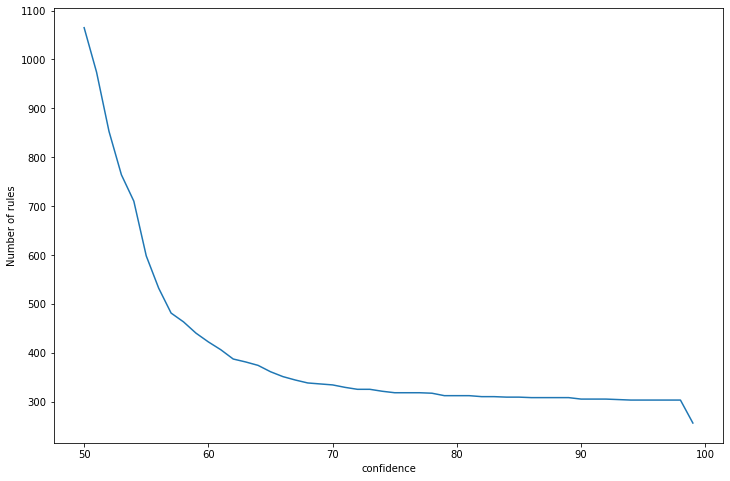

In [29]:
#confidence vs number of items
#This graphic can be helpful to decide which value of confidence to choose.
len_rules = []
max_conf = 100
for i in range(50, max_conf):
    rules = apriori(X, target="r", supp=20, zmin=zmin, conf=i, report="aScl")
    len_rules.append(len(rules))
plt.plot(np.arange(50, max_conf), len_rules)
plt.xlabel("confidence")
plt.ylabel("Number of rules")

plt.show()

In [30]:
conf = 70
rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
rules_df.sort_values(by="lift", axis=0, ascending=False)

,consequent,antecedent,abs_support,%_support,confidence,lift
0,"(435.5, 652.75]_sample_width","((435.5, 652.75]_channels, (435.5, 652.75]_fra...",214,24.597701,1.000000,4.009217
84,"(218.25, 435.5]_frame_width","((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",215,24.712644,1.000000,4.009217
103,"(218.25, 435.5]_frame_rate","((218.25, 435.5]_stft_max, (218.25, 435.5]_sam...",215,24.712644,1.000000,4.009217
102,"(218.25, 435.5]_sample_width","((218.25, 435.5]_stft_max, (218.25, 435.5]_fra...",215,24.712644,1.000000,4.009217
97,"(218.25, 435.5]_frame_width","((218.25, 435.5]_stft_max, (218.25, 435.5]_cha...",215,24.712644,1.000000,4.009217
...,...,...,...,...,...,...
328,F,"((0.999, 218.25]_stft_min,)",161,18.505747,0.738532,1.463606
325,F,"((0.999, 218.25]_stft_min, (0.999, 218.25]_sc_...",161,18.505747,0.738532,1.463606
313,M,"((0.999, 218.25]_zero_crossings_rate,)",154,17.701149,0.706422,1.425956
319,-1_emp,"((652.75, 870.0]_intensity,)",163,18.735632,0.747706,1.387003


In [31]:
conf = 50
rules = apriori(X, target="r", supp=20, zmin=zmin, conf=conf, report="aScl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
rules_df.sort_values(by="lift", axis=0, ascending=False)

,consequent,antecedent,abs_support,%_support,confidence,lift
0,happy,"(1_emp,)",127,14.597701,0.651282,4.461538
1,calm,"(0_emp,)",138,15.862069,0.669903,4.223301
232,"(218.25, 435.5]_stft_max","((218.25, 435.5]_frame_width, (218.25, 435.5]_...",215,24.712644,1.000000,4.009217
213,"(435.5, 652.75]_stft_max","((435.5, 652.75]_frame_rate,)",217,24.942529,1.000000,4.009217
217,"(435.5, 652.75]_sample_width","((435.5, 652.75]_stft_max,)",217,24.942529,1.000000,4.009217
...,...,...,...,...,...,...
861,-1_emp,"((652.75, 870.0]_channels,)",111,12.758621,0.509174,0.944524
981,-1_emp,"((0.999, 218.25]_stft_mean, F)",102,11.724138,0.507463,0.941349
932,-1_emp,"((652.75, 870.0]_sc_mean,)",110,12.643678,0.504587,0.936015
196,-1_emp,"((435.5, 652.75]_sc_mean,)",109,12.528736,0.502304,0.931780


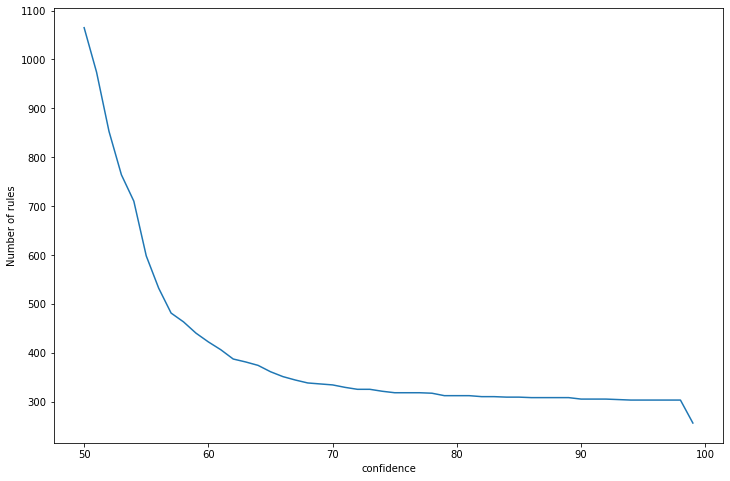

In [32]:
#confidence vs number of items
#This graphic can be helpful to decide which value of confidence to choose.
len_rules = []
max_conf = 100
for i in range(50, max_conf):
    rules = apriori(X, target="r", supp=20, zmin=zmin, conf=i, report="aScl")
    len_rules.append(len(rules))
plt.plot(np.arange(50, max_conf), len_rules)
plt.xlabel("confidence")
plt.ylabel("Number of rules")

plt.show()

Text(0, 0.5, 'Lift')

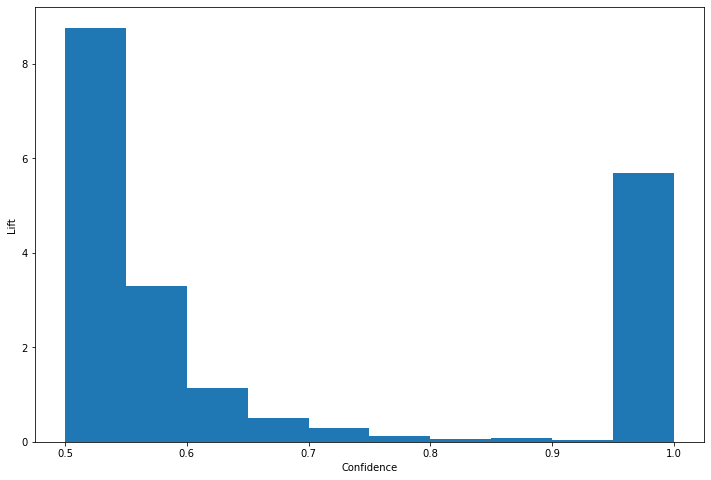

In [33]:
plt.hist(rules_df['confidence'], density = True)
plt.xlabel("Confidence")
plt.ylabel("Lift")

### Exploiting association rules

#### Sex

In [34]:
y_real = np.array(df_orig["sex"])

In [41]:
rules_df[(rules_df["consequent"]=="F") & (rules_df["confidence"]>=0.80)]

,consequent,antecedent,abs_support,%_support,confidence,lift
402,F,"((218.25, 435.5]_stft_min,)",177,20.344828,0.815668,1.616472
899,F,"((0.999, 218.25]_mfcc_mean,)",203,23.333333,0.931193,1.845416
913,F,"((0.999, 218.25]_mfcc_max,)",195,22.413793,0.894495,1.772690
978,F,"((652.75, 870.0]_stft_std,)",196,22.528736,0.899083,1.781781
982,F,"((0.999, 218.25]_stft_mean,)",201,23.103448,0.922018,1.827235


In [42]:
rules_df[(rules_df["consequent"]=="M") & (rules_df["confidence"]>=0.80)]

,consequent,antecedent,abs_support,%_support,confidence,lift
498,M,"((652.75, 870.0]_stft_min,)",215,24.712644,0.986239,1.990783
554,M,"((652.75, 870.0]_mfcc_mean,)",183,21.034483,0.839450,1.694481
1004,M,"((652.75, 870.0]_stft_mean,)",187,21.494253,0.857798,1.731518
1026,M,"((0.999, 218.25]_stft_std,)",196,22.528736,0.899083,1.814853


In [64]:
y_pred0 = []
for ind in df_orig.index:
    if (df_orig["stft_mean_Bins"][ind] == '(0.999, 218.25]_stft_mean') or (df_orig["stft_std_Bins"][ind] == '(652.75, 870.0]_stft_std') or (df_orig["mfcc_max_Bins"][ind] == '(0.999, 218.25]_mfcc_max') or (df_orig["mfcc_mean_Bins"][ind] == '(0.999, 218.25]_mfcc_mean'):
        y_pred0.append('F')
    elif (df_orig["stft_min_Bins"][ind] == '(652.75, 870.0]_stft_min') or (df_orig["stft_mean_Bins"][ind] == '(652.75, 870.0]_stft_mean') or (df_orig["stft_std_Bins"][ind] == '(0.999, 218.25]_stft_std'):
        y_pred0.append('M')
    else:
        y_pred0.append('none')

In [65]:
print(classification_report(y_real, y_pred0))

              precision    recall  f1-score   support

           F       0.83      0.81      0.82       439
           M       0.92      0.61      0.74       431
        none       0.00      0.00      0.00         0

    accuracy                           0.71       870
   macro avg       0.59      0.47      0.52       870
weighted avg       0.88      0.71      0.78       870



C:\Users\claud\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\claud\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\claud\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
y_pred1 = []
for ind in df_orig.index:
    if (df_orig["mfcc_mean_Bins"][ind] == '(0.999, 218.25]_mfcc_mean'):
        y_pred1.append('F')
    elif (df_orig["stft_min_Bins"][ind] == '(652.75, 870.0]_stft_min'):
        y_pred1.append('M')
    else:
        y_pred1.append('none')

In [67]:
print(classification_report(y_real, y_pred1))

              precision    recall  f1-score   support

           F       0.93      0.46      0.62       439
           M       0.99      0.49      0.66       431
        none       0.00      0.00      0.00         0

    accuracy                           0.48       870
   macro avg       0.64      0.32      0.43       870
weighted avg       0.96      0.48      0.64       870



C:\Users\claud\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\claud\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\claud\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Emotion

In [85]:
rules_df[(rules_df["consequent"]=="happy") & (rules_df["confidence"]>=0.65)]

,consequent,antecedent,abs_support,%_support,confidence,lift
0,happy,"(1_emp,)",127,14.597701,0.651282,4.461538


In [86]:
rules_df[(rules_df["consequent"]=="calm") & (rules_df["confidence"]>=0.65)]

,consequent,antecedent,abs_support,%_support,confidence,lift
1,calm,"(0_emp,)",138,15.862069,0.669903,4.223301
